In [3]:
# HIDDEN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
pd.set_option('display.max_rows', 100)
sns.set(rc={'figure.figsize':(12,6)})

import warnings
warnings.filterwarnings("ignore")


In [4]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
recidivism = (
    pd.read_csv(url)
    .drop(['name', 'first', 'last'], axis=1)
)

# COMPAS Analysis

### Individual Fairness

* Define individual similarity measure on COMPAS
* Investigate COMPAS w/r/t individual fairness

### Define a Metric

For comparing similarity between individuals, use 'task relevant' variables:
* Criminal History
* Severity of current charge
* Age of defendant (associated w/recidivism)

'task relevant' variables reflect *effort*.

To start:
* Don't use Race, Gender
* Use Euclidean Distance for numeric variables
* Use "Hard Match" for categorical variables

In [5]:
metric_vars = [
    'age', 'juv_fel_count', 'juv_misd_count', 
    'priors_count', 'c_charge_degree', 'c_charge_desc']

other_vars = ['decile_score', 'is_recid', 'race', 'sex']

### Metric Base Class

* On instantiation, gather column types (to know how to process them)
* Define a `dist` method that takes in two rows, outputs a non-negative number (metric)

In [6]:
class CompasMetricBase(object):
    
    def __init__(self, df, metric_vars):
        
        self.vars = metric_vars
        
        df = df[metric_vars]
        self.nums = df.dtypes.loc[lambda x:(x == 'float') | (x == 'int')].index
        self.cats = df.dtypes.loc[lambda x:x == 'object'].index
        return
    
        
    def dist(self, ser1, ser2):
        
        # sum of squares
        # dnum = np.sqrt(((ser1.loc[self.nums] - ser2.loc[self.nums])**2).sum())
        
        # absolute difference
        dnum = np.abs((ser1.loc[self.nums] - ser2.loc[self.nums])).sum()
        
        # exact-match
        dcat = (1 - (ser1.loc[self.cats] == ser2.loc[self.cats]).astype(int)).sum()
        
        return (dnum + dcat) / len(self.vars)

In [7]:
# Ignore this
def min_max_normalize(df):
    
    return (df - df.min()) / (df.max() - df.min())

In [8]:
df = recidivism[metric_vars + other_vars]

In [9]:
d = CompasMetricBase(df, metric_vars)
# d = MaxSimilarityMetric(df, metric_vars)
# d = CompasMetricBow(df, metric_vars)
# d = CompasMetricLuckEgal(df, metric_vars)

### Compute pairwise similarities

* Too many to compute exhaustively
    - COMPAS is ~7k individuals
    - Pairwise distances ~5.2M pairs
* Procedure:
    - Randomly sample 10k pairs
    - Compute pairwise similarity of those pairs (`d`)
    - Calculate pairwise similarity of outcomes (`D`)

In [10]:
samp = 10000

np.random.seed(42)

a = df.copy()
a[d.nums] = min_max_normalize(a[d.nums]) # comment out (for luck egalitarianism)

dm = []
for i,j in np.random.choice(a.index, size=(samp,2)):
    v1, v2 = a.loc[i], a.iloc[j]
    dist = d.dist(v1, v2)
    D = np.abs(v1['decile_score'] - v2['decile_score']) / 10
    dm.append((i, j, dist, D))
        
dm = pd.DataFrame(dm, columns=['idx_1', 'idx_2', 'd', 'D'])

### Results: pairs + (d, D)

In [11]:
dm

,idx_1,idx_2,d,D
0,860,5390,0.181849,0.0
1,5226,5191,0.357287,0.7
2,3772,3092,0.396536,0.6
3,5734,6265,0.047233,0.2
4,466,5334,0.406444,0.1
...,...,...,...,...
9995,1881,6049,0.206028,0.4
9996,3898,4113,0.365497,0.2
9997,1178,3855,0.220310,0.2
9998,5625,4873,0.412618,0.0


### Select 'unfair' decisions based on (d,D)-Fairness condition

The Lipschitz condition for fairness is:

$$D(S(x), S(y)) \leq d(x,y)$$

* We calculate the proportion of pairs that don't satisfy the fair decision condition:

In [12]:
unfairs = dm[dm['d'] < dm['D']]

In [13]:
len(unfairs) / len(dm)

0.5249

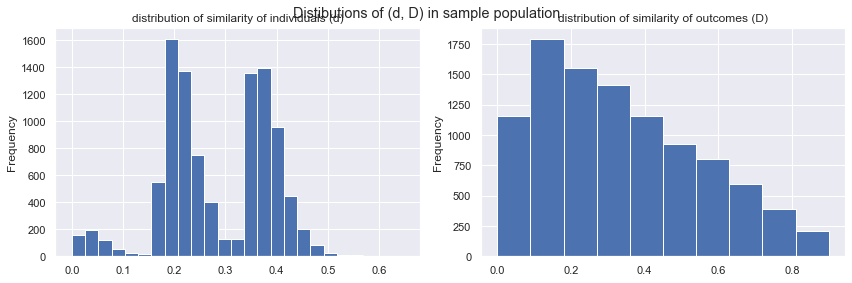

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

dm['d'].plot(kind='hist', bins=25, ax=ax1, title='distribution of similarity of individuals (d)')
dm['D'].plot(kind='hist', ax=ax2, title='distribution of similarity of outcomes (D)')

plt.suptitle('Distibutions of (d, D) in sample population')
plt.tight_layout();

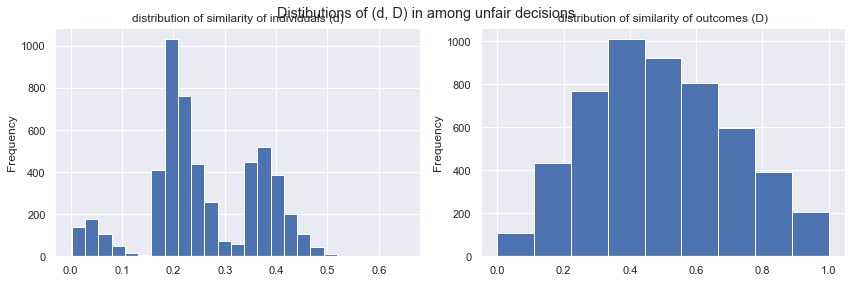

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

unfairs['d'].plot(kind='hist', bins=25, ax=ax1, title='distribution of similarity of individuals (d)')
unfairs['D'].plot(kind='hist', bins=np.linspace(0,1,10), ax=ax2, title='distribution of similarity of outcomes (D)')

plt.suptitle('Distibutions of (d, D) in among unfair decisions')
plt.tight_layout();

### Question: thinking about what goes into our metrics

* How are variables individually weighted in the similarity calculation?
    - which variable do you think has the most influence?
    - you can train a regression model to learn `d` and look at the importance of each variable
* Are `d` and `D` appropriately comparable?
    - can you think of a choice of metric `d` or `D` so that fairness always holds?
    - can you think of a choice of metric `D` so that fairness almost never holds?    
* Return to top and make metric tweaks!

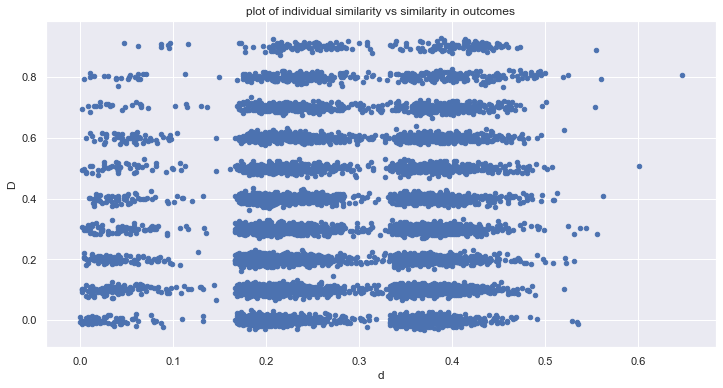

In [16]:
jittered = dm.assign(
    D=(dm['D'] + np.random.normal(0,0.01, size=dm.shape[0]))
)

jittered.plot(kind='scatter', x='d', y='D', c='b', title='plot of individual similarity vs similarity in outcomes');

### Rejoin the similarity pairs to the original data

* Analyze the (lack of) fairness in terms of original data

In [17]:
def rejoin(dm, df):
    
    # join similarities with original data
    # prefix=1,2 denote data attached to each individual in pair
    m = (
        dm
        .merge(df, left_on='idx_1', right_index=True)
        .merge(df, left_on='idx_2', right_index=True, suffixes=['_1', '_2'])
        .sort_index(axis=1)
    )
    
    # extract the data associated to the higher COMPAS score
    # when an unfair decision is made, this is the individual impacted most by decision
    cols1 = m['decile_score_1'] < m['decile_score_2']
    cols2 = m['decile_score_1'] > m['decile_score_2']
    repl_cols = ['race', 'decile_score', 'is_recid', 'c_charge_degree', 'c_charge_desc', 'sex', 'age']

    for c in repl_cols:
        m.loc[cols1, c] = m.loc[cols1, '%s_2' % c]
        m.loc[cols2, c] = m.loc[cols2, '%s_1' % c]
    
    # Calculate if a FP or FN occurred within the pair
    FP = ((m.decile_score >= 5) & (m.is_recid == 0)).astype(int)
    FN = (
        ((m['decile_score_1'] < m['decile_score_2']) & (m['decile_score_1'] < 5) & (m['is_recid_1'] == 1)) |
        ((m['decile_score_2'] < m['decile_score_1']) & (m['decile_score_2'] < 5) & (m['is_recid_2'] == 1))
    ).astype(int)
    
    m = m.assign(FP=FP, FN=FN) 
    
    return m

In [18]:
r = rejoin(dm, df)

### Individuals distance ~0.31 apart

* Note, that not everyone is similar in the same way!
* Larger difference in age could be made up by a smaller distance in prior_count, for example
* Which variables have largest influence?

In [ ]:
(
    r.loc[
        (r.d < 0.32) & (r.d > 0.30), 
        [c for c in r.columns if (('_1' in c) or ('_2' in c))]
    ].loc[:,[c for c in r.columns if c[:-2] in metric_vars]]
)

### Very unfair pairs:
* individuals nearly identical (< 0.02)
* outcomes very different (> 0.5)

What are the (differing) characteristics of these pairs?

In [ ]:
rejoin(
    unfairs[(unfairs['d'] < 0.11) & (unfairs['D'] > 0.5)],
    df
).T

### Focus on unfair decisions

In [ ]:
a = rejoin(unfairs, df)

In [ ]:
pd.concat([
    a.race.value_counts(normalize=True).rename('unfairly treated'),
    recidivism.race.value_counts(normalize=True).rename('population')
], axis=1).plot(kind='bar', title='distibution of impacts from unfair decisions by race');

### Average difference in outcomes by race (among unfair decisions)

* Scores of Black defendants among unfair decisions are higher than those of White defendants

In [ ]:
sns.barplot(data=a, x='race', y='D');

### Recidivism Rate of by race among the higher of the COMPAS scores in unfair decisions

* The difference in Black vs White defendants may be due to the high FN rate in White population

In [ ]:
sns.barplot(data=a, x='race', y='is_recid');

In [ ]:
cdict = {'Other': 'b', 'Caucasian': 'orange', 'African-American': 'green', 'Hispanic': 'red', 'Asian': 'purple', 'Native American': 'brown'}
jittered = a.assign(
    D=(a['D'] + np.random.normal(0,0.02, size=a.shape[0]))
)

ax = jittered.plot(kind='scatter', x='d', y='D', c=a['race'].replace(cdict), alpha=0.4, title='(d,D) by Race');

In [ ]:
pd.concat([
    recidivism.c_charge_desc.value_counts(normalize=True).iloc[:10].rename('population'), 
    a.c_charge_desc.value_counts(normalize=True).iloc[:10].rename('unfairly treated')
], axis=1).plot(kind='bar', title='Distribution of charge description');

In [ ]:
pd.concat([
    recidivism.c_charge_degree.value_counts(normalize=True).iloc[:10].rename('population'), 
    a.c_charge_degree.value_counts(normalize=True).iloc[:10].rename('unfairly treated')
], axis=1).plot(kind='bar', title='Charge Degree (Felony vs Misd) distribution');

### Average age by race/sex in unfair decisions
* Pretty even

In [ ]:
sns.barplot(data=a, x='race', y='age', hue='sex');

### False Positive Rate by race in unfair decisions

In [ ]:
sns.barplot(data=a, x='race', y='FP');

### False Negative Rate by race in unfair decisions

In [ ]:
sns.barplot(data=a, x='race', y='FN');

### Other metric definitions

* What tweaks can you think of?
* Make your own and try them out!

In [ ]:
class MaxSimilarityMetric(CompasMetricBase):
    
    def dist(self, ser1, ser2):
        
        # absolute difference
        dnum = np.abs((ser1.loc[self.nums] - ser2.loc[self.nums])).max()
        
        # exact-match
        dcat = (1 - (ser1.loc[self.cats] == ser2.loc[self.cats]).astype(int)).max()
        
        return max(dnum, dcat)

In [ ]:
recidivism.c_charge_desc.value_counts()

In [ ]:
class CompasMetricBow(object):
    
    def __init__(self, df, metric_vars):
        
        self.vars = metric_vars
        
        df = df[metric_vars]
        self.nums = df.dtypes.loc[lambda x:(x == 'float') | (x == 'int')].index
        self.cats = df.dtypes.loc[lambda x:x == 'object'].index
        
        from sklearn.feature_extraction.text import CountVectorizer
        dv = CountVectorizer()
        bow = dv.fit_transform(df['c_charge_desc'].replace(np.nan, '')).todense()
        self.bow = pd.DataFrame(bow, columns=sorted(dv.vocabulary_, key=lambda x:x[1]))
        
        return
    
        
    def dist(self, ser1, ser2):

        # absolute difference
        dnum = np.abs((ser1.loc[self.nums] - ser2.loc[self.nums])).sum()
        
        # exact-match for charge degree (M vs F)
        dcat1 = (1 - (ser1.loc[['c_charge_degree']] == ser2.loc[['c_charge_degree']]).astype(int)).sum()
        
        # bow for charge description
        bow = self.bow
        i1, i2 = ser1.name, ser2.name
        dot = (bow.loc[i1] * bow.loc[i2]).sum()
        N1 = np.sqrt((bow.loc[2]**2).sum())
        N2 = np.sqrt((bow.loc[3]**2).sum())
        dcat2 = dot / (N1 * N2)
        
        return (dnum + dcat1 + dcat2) / len(self.vars)

In [ ]:
class CompasMetricLuckEgal(object):
    
    def __init__(self, df, metric_vars):
        
        self.vars = metric_vars
        
        df = df[metric_vars + ['race']]
        self.nums = df.dtypes.loc[lambda x:(x == 'float') | (x == 'int')].index
        self.cats = df.dtypes.loc[lambda x:x == 'object'].index
        
        cdfs = {}
        for c in d.nums:
            cdfs[c] = (
                df
                .groupby('race')[c]
                .apply(self._calculate_cdf)
                .reset_index()
                .pivot(index='level_1', columns='race', values=c)
                .fillna(1.0)
            )
            
            if 'Asian' not in cdfs[c].columns:
                cdfs[c]['Asian'] = 1.0
            
        self.cdfs = cdfs
        
        return
    
        
    def dist(self, ser1, ser2):

        dnum = 0
        for c in self.nums:
            cdf = self.cdfs[c]
            p1 = cdf.loc[ser1[c], ser1['race']]
            p2 = cdf.loc[ser2[c], ser2['race']]
            dnum = dnum + np.abs(p1 - p2)
        
        # exact-match for charge degree (M vs F)
        dcat = (1 - (ser1.loc[d.cats] == ser2.loc[d.cats]).astype(int)).sum()
    
        return (dnum + dcat) / len(self.vars)
    
    
    def _calculate_cdf(self, col):

        cdf = col.value_counts(normalize=True).sort_index().cumsum()
        reindexed_cdf = cdf.reindex(
            pd.RangeIndex(
                start=cdf.index.min(), 
                stop=(cdf.index.max() + 1)
            ), method='nearest')

        return reindexed_cdf